In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MultiLabelBinarizer  


In [2]:
df = pd.read_csv('E:/UIT/Năm-2/Kì-2/Predicting-Popularity-of-Vietnamese-Articles/2. Data Pre-processing/dataset3.csv')

In [3]:
df['popularity_score'] = (0.1 * df['comments'] + 0.1 * df['interactions'] ) / (df['time_since_posted'] + 1e-10)
df.drop(columns=['time_since_posted'], inplace=True)

### Code xử lý tags

In [4]:
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)
df_dev, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

In [5]:
# Chuẩn hóa tag: thay khoảng trắng bằng _
def normalize_tag(tag: str) -> str:
    return tag.replace(' ', '_')    
# Tạo tag_text cho từng bộ
def tags_to_doc(cat_dict, frequent_tag_set=None):
    if frequent_tag_set:
        return ' '.join(
            normalize_tag(tag)
            for tags in cat_dict.values()
            for tag in tags
            if normalize_tag(tag) in frequent_tag_set
        )
    else:
        return ' '.join(
            normalize_tag(tag)
            for tags in cat_dict.values()
            for tag in tags
        )
import ast

def safe_eval(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return {}
    return x

df_train['classified_tags'] = df_train['classified_tags'].apply(safe_eval)
df_dev['classified_tags'] = df_dev['classified_tags'].apply(safe_eval)
df_test['classified_tags'] = df_test['classified_tags'].apply(safe_eval)
# 1. Tìm các tag phổ biến chỉ trên tập train
all_tags_train = []
for row in df_train['classified_tags']:
    for tags in row.values():
        all_tags_train.extend([normalize_tag(tag) for tag in tags])

k = 5
tag_counts = Counter(all_tags_train)
frequent_tags = [tag for tag, count in tag_counts.items() if count >= k]
frequent_tags_set = set(frequent_tags)

In [6]:
# 2. Tạo tag_text cho train/dev/test, chỉ giữ những tag phổ biến
df_train['tag_text'] = df_train['classified_tags'].apply(lambda x: tags_to_doc(x, frequent_tags_set))
df_dev['tag_text'] = df_dev['classified_tags'].apply(lambda x: tags_to_doc(x, frequent_tags_set))
df_test['tag_text'] = df_test['classified_tags'].apply(lambda x: tags_to_doc(x, frequent_tags_set))
from sklearn.feature_extraction.text import TfidfVectorizer
# 3. Fit TF-IDF trên train và transform trên dev/test
vectorizer = TfidfVectorizer(vocabulary=frequent_tags)
X_train_tfidf = vectorizer.fit_transform(df_train['tag_text'])
X_dev_tfidf = vectorizer.transform(df_dev['tag_text'])
X_test_tfidf = vectorizer.transform(df_test['tag_text'])

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:1368: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [7]:
y_train = df_train['popularity_score']
X_train = df_train.drop(columns=['title','date','popularity_score','comments', 'interactions', 'tags', 'classified_tags', 'tag_text'])

y_test = df_test['popularity_score']
X_test = df_test.drop(columns=['title','date','popularity_score','comments', 'interactions', 'tags', 'classified_tags', 'tag_text'])

y_dev = df_dev['popularity_score']
X_dev = df_dev.drop(columns=['title','date','popularity_score','comments', 'interactions', 'tags', 'classified_tags', 'tag_text'])

In [8]:
cols_to_exclude = ['category', 'posted_hour', 'has_comments', 'has_interactions', 'has_number', 
                   'has_emotion', 'is_question','has_famous_people_tag', 'has_place_tag', 'has_event_tag', 
                   'has_org_tag', 'is_weekday'
    ]

# Loại trừ các cột cols_to_exclude ra khỏi tập chuẩn hóa
X_train_to_scale = X_train.drop(columns=cols_to_exclude)
X_dev_to_scale = X_dev.drop(columns=cols_to_exclude)
X_test_to_scale = X_test.drop(columns=cols_to_exclude)

# Chuẩn hóa
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_to_scale), columns=X_train_to_scale.columns)
X_dev_scaled = pd.DataFrame(scaler.transform(X_dev_to_scale), columns=X_dev_to_scale.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_to_scale), columns=X_test_to_scale.columns)

# Gộp lại với các cột đã loại trừ
X_train_scaled = pd.concat([X_train_scaled, X_train[cols_to_exclude].reset_index(drop=True)], axis=1)
X_dev_scaled = pd.concat([X_dev_scaled, X_dev[cols_to_exclude].reset_index(drop=True)], axis=1)
X_test_scaled = pd.concat([X_test_scaled, X_test[cols_to_exclude].reset_index(drop=True)], axis=1)

In [9]:
from sklearn.preprocessing import OneHotEncoder

# Tạo encoder cho category
category_encoder = OneHotEncoder(sparse_output=False, categories=[np.array(range(1, 10))])
category_encoded = category_encoder.fit_transform(X_train[['category']])
category_columns = [f'category_{i}' for i in range(1, 10)]
category_df = pd.DataFrame(category_encoded, columns=category_columns)

# Kết hợp với dữ liệu số đã chuẩn hóa
X_train_scaled = X_train_scaled.drop(['category'], axis=1)
X_train_scaled = pd.concat([X_train_scaled, category_df], axis=1)

# Tương tự cho dev và test
category_encoded_dev = category_encoder.transform(X_dev_scaled[['category']])
category_df_dev = pd.DataFrame(category_encoded_dev, columns=category_columns)
X_dev_scaled = X_dev_scaled.drop(['category'], axis=1)
X_dev_scaled = pd.concat([X_dev_scaled, category_df_dev], axis=1)

category_encoded_test = category_encoder.transform(X_test_scaled[['category']])
category_df_test = pd.DataFrame(category_encoded_test, columns=category_columns)
X_test_scaled = X_test_scaled.drop(['category'], axis=1)
X_test_scaled = pd.concat([X_test_scaled, category_df_test], axis=1)

In [10]:
from scipy.sparse import hstack, csr_matrix
import numpy as np

# Chuyển đổi DataFrame thành sparse matrix
X_train_scaled_sparse = csr_matrix(X_train_scaled.astype(float).values)
X_dev_scaled_sparse = csr_matrix(X_dev_scaled.astype(float).values)
X_test_scaled_sparse = csr_matrix(X_test_scaled.astype(float).values)

# Kết hợp dữ liệu
X_train_combined = hstack([X_train_tfidf, X_train_scaled_sparse])
X_dev_combined = hstack([X_dev_tfidf, X_dev_scaled_sparse])
X_test_combined = hstack([X_test_tfidf, X_test_scaled_sparse])

# In thông tin để kiểm tra
print("Shape của X_train_combined:", X_train_combined.shape)
print("Shape của X_dev_combined:", X_dev_combined.shape)
print("Shape của X_test_combined:", X_test_combined.shape)

Shape của X_train_combined: (3717, 405)
Shape của X_dev_combined: (796, 405)
Shape của X_test_combined: (797, 405)


## Sử dụng kfold kết hợp train-dev-test, áp dụng GridSearchCV để tim tham số tốt nhất ##

In [11]:
from xgboost import XGBRegressor

# Định nghĩa K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV cho từng mô hình
models = {
    'XGBoost Regressor': {
        'estimator': XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'Ridge Regression': {
        'estimator': Ridge(),
        'param_grid': {'alpha': [0.01, 0.1, 1, 10, 100]}
    },
    'Random Forest Regressor': {
        'estimator': RandomForestRegressor(random_state=42),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [5, 7, 10],
            'min_samples_split': [2, 5]
        }
    }
}

# Lưu trữ mô hình tốt nhất và kết quả
best_models = {}
results = {}

for model_name, config in models.items():
    print(f"\n--- Huấn luyện {model_name} ---")

    # Khởi tạo GridSearchCV
    grid = GridSearchCV(
        estimator=config['estimator'],
        param_grid=config['param_grid'],
        scoring='neg_root_mean_squared_error',
        cv=kf,
        verbose=1,
        n_jobs=-1
    )

    # Fit GridSearchCV
    grid.fit(X_train_combined, y_train)

    # Lấy mô hình tốt nhất
    best_model = grid.best_estimator_
    best_models[model_name] = best_model

    # In siêu tham số tốt nhất
    print(f"Best parameters ({model_name}): {grid.best_params_}")
    print(f"Best CV score (neg RMSE): {grid.best_score_:.4f}")

    # Dự đoán trên dev
    y_dev_pred = best_model.predict(X_dev_combined)

    # Tính RMSE và R²
    dev_rmse = mean_squared_error(y_dev, y_dev_pred)**0.5
    dev_r2 = r2_score(y_dev, y_dev_pred)

    # Lưu kết quả
    results[model_name] = {
        'dev_rmse': dev_rmse,
        'dev_r2': dev_r2,

    }

    # In kết quả
    print(f"\n{model_name} (best parameters)")

    # Nếu muốn hiểu mô hình hoạt động như thế nào thì chạy luôn cái này
    # if model_name in ['Ridge Regression']:
    #     print("Hệ số (cho các thành phần chính):")
    #     for i, coef in enumerate(best_model.coef_):
    #         print(f"  PC{i+1}: {coef:.4f}")
    # else:  # Random Forest hoặc XGBoost
    #     print("Độ quan trọng của các thành phần chính:")
    #     for i, importance in enumerate(best_model.feature_importances_):
    #         print(f"  PC{i+1}: {importance:.4f}")

    print("Dev set:")
    print(f"RMSE: {dev_rmse:.4f}")
    print(f"R²: {dev_r2:.4f}")



--- Huấn luyện XGBoost Regressor ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters (XGBoost Regressor): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best CV score (neg RMSE): -0.0007

XGBoost Regressor (best parameters)
Dev set:
RMSE: 0.0007
R²: 0.4330

--- Huấn luyện Ridge Regression ---
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters (Ridge Regression): {'alpha': 10}
Best CV score (neg RMSE): -0.0007

Ridge Regression (best parameters)
Dev set:
RMSE: 0.0007
R²: 0.4202

--- Huấn luyện Random Forest Regressor ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters (Random Forest Regressor): {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score (neg RMSE): -0.0007

Random Forest Regressor (best parameters)
Dev set:
RMSE: 0.0007
R²: 0.4247


In [12]:
# Dùng mô hình tốt nhất từ GridSearch
xgb_model = best_models['XGBoost Regressor']
xgb_model.fit(X_train_combined, y_train)

# Dự đoán
y_pred_xgb = xgb_model.predict(X_test_combined)

# Đánh giá
print("XGBoost - RMSE:", mean_squared_error(y_test, y_pred_xgb)**0.5)
print("XGBoost - R2 score:", r2_score(y_test, y_pred_xgb))


XGBoost - RMSE: 0.000631054700010563
XGBoost - R2 score: 0.44871620927907474


In [13]:
# Dùng mô hình tốt nhất từ GridSearch
rf_model = best_models['Random Forest Regressor']
rf_model.fit(X_train_combined, y_train)

# Dự đoán
y_pred_rf = rf_model.predict(X_test_combined)

# Đánh giá
print("Random Forest - RMSE:", mean_squared_error(y_test, y_pred_rf)**0.5)
print("Random Forest - R2 score:", r2_score(y_test, y_pred_rf))


Random Forest - RMSE: 0.0006229142837759367
Random Forest - R2 score: 0.462847265304254


In [14]:
# Dùng mô hình tốt nhất từ GridSearch
rr_model = best_models['Ridge Regression']
rr_model.fit(X_train_combined, y_train)

# Dự đoán
y_pred_rr = rr_model.predict(X_test_combined)

# Đánh giá
print("Ridge Regression - RMSE:", mean_squared_error(y_test, y_pred_rr)**0.5)
print("Ridge Regression - R2 score:", r2_score(y_test, y_pred_rr))

Ridge Regression - RMSE: 0.0006364741664923361
Ridge Regression - R2 score: 0.4392067547706693


### KIỂM ĐỊNH THỐNG KÊ


=== KIỂM ĐỊNH TÍNH CHUẨN CỦA PHẦN DƯ ===

1.1. Shapiro-Wilk test:
Thống kê: 0.8884
p-value: 0.0000
Kết luận: Phần dư không tuân theo phân phối chuẩn

1.2. Jarque-Bera test:
Thống kê: 760.1636
p-value: 0.0000
Kết luận: Phần dư không tuân theo phân phối chuẩn

=== KIỂM ĐỊNH TÍNH ĐỘC LẬP CỦA PHẦN DƯ ===

2.1. Durbin-Watson test:
Thống kê: 2.0133
Kết luận: Phần dư độc lập

2.2. Ljung-Box test:
Thống kê cho các lag [5, 10, 15]: ['4.1190', '5.1669', '16.8936']
p-value cho các lag [5, 10, 15]: ['0.5324', '0.8798', '0.3253']
Kết luận: Không có tự tương quan

=== KIỂM ĐỊNH TÍNH ĐỒNG NHẤT CỦA PHƯƠNG SAI ===

3.1. Breusch-Pagan test:
Thống kê: 378.5979
p-value: 0.0000
Kết luận: Phương sai không đồng nhất

3.2. Goldfeld-Quandt test:
Thống kê: 1.1125
p-value: 0.1508
Kết luận: Phương sai đồng nhất

=== KIỂM ĐỊNH ĐA CỘNG TUYẾN (VIF) ===

Giá trị VIF của các biến số:
                 Biến          VIF
            wordcount 7.252000e+00
               images 4.242297e+00
               videos 1.706978

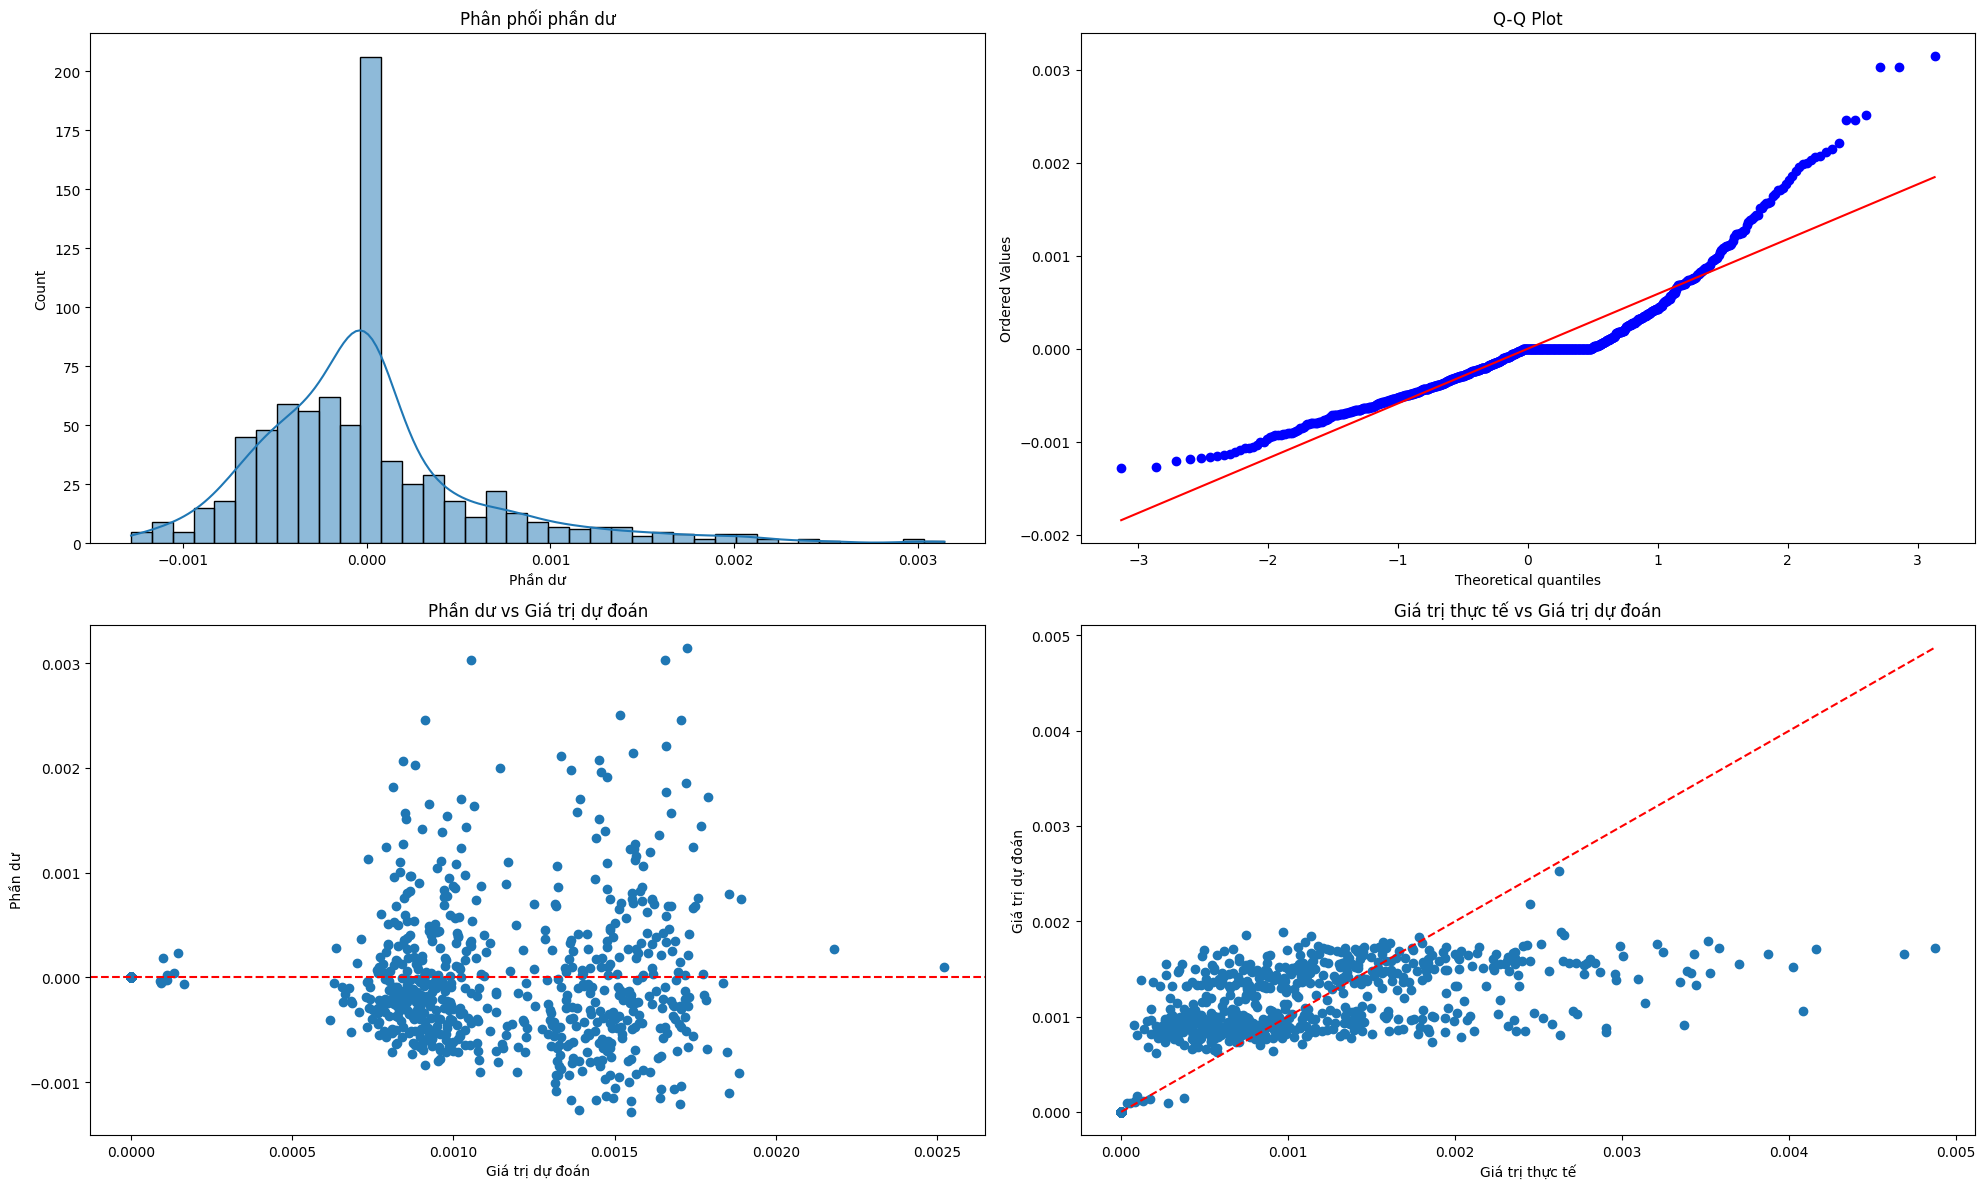


=== CÁC METRIC ĐÁNH GIÁ MÔ HÌNH ===
RMSE: 0.0006
R²: 0.4628
MAE: 0.0004
MAPE: 69.18%
Giải thích phương sai: 0.4439


In [22]:
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox, het_goldfeldquandt
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

y_pred = y_pred_rf

# Tính toán phần dư
residuals = y_test - y_pred

# 1. Kiểm định tính chuẩn của phần dư
print("\n=== KIỂM ĐỊNH TÍNH CHUẨN CỦA PHẦN DƯ ===")
shapiro_test = stats.shapiro(residuals)
print("\n1.1. Shapiro-Wilk test:")
print(f"Thống kê: {shapiro_test[0]:.4f}")
print(f"p-value: {shapiro_test[1]:.4f}")
print(f"Kết luận: {'Phần dư tuân theo phân phối chuẩn' if shapiro_test[1] > 0.05 else 'Phần dư không tuân theo phân phối chuẩn'}")

jb_test = jarque_bera(residuals)
print("\n1.2. Jarque-Bera test:")
print(f"Thống kê: {jb_test[0]:.4f}")
print(f"p-value: {jb_test[1]:.4f}")
print(f"Kết luận: {'Phần dư tuân theo phân phối chuẩn' if jb_test[1] > 0.05 else 'Phần dư không tuân theo phân phối chuẩn'}")

# 2. Kiểm định tính độc lập của phần dư
print("\n=== KIỂM ĐỊNH TÍNH ĐỘC LẬP CỦA PHẦN DƯ ===")
dw_stat = durbin_watson(residuals)
print("\n2.1. Durbin-Watson test:")
print(f"Thống kê: {dw_stat:.4f}")
print(f"Kết luận: {'Phần dư độc lập' if 1.5 < dw_stat < 2.5 else 'Phần dư có tương quan'}")

lb_test = acorr_ljungbox(residuals, lags=[5, 10, 15], return_df=True)
print("\n2.2. Ljung-Box test:")
print("Thống kê cho các lag [5, 10, 15]:", [f"{stat:.4f}" for stat in lb_test['lb_stat']])
print("p-value cho các lag [5, 10, 15]:", [f"{pval:.4f}" for pval in lb_test['lb_pvalue']])
print(f"Kết luận: {'Không có tự tương quan' if all(p > 0.05 for p in lb_test['lb_pvalue']) else 'Có tự tương quan'}")

# 3. Kiểm định tính đồng nhất của phương sai
print("\n=== KIỂM ĐỊNH TÍNH ĐỒNG NHẤT CỦA PHƯƠNG SAI ===")
# Chỉ dùng các biến số gốc đã chuẩn hóa (không dùng TF-IDF)
numeric_columns = [
    'wordcount', 'images', 'videos', 'popularity_score',
    'title_length', 'title_score', 'sentiment_score',
    'positive', 'negative', 'neutral', 'category',
    'posted_hour', 'has_comments', 'has_interactions',
    'has_number', 'has_emotion', 'is_question',
    'has_famous_people_tag', 'has_place_tag',
    'has_event_tag', 'has_org_tag', 'is_weekday'
]
# Lấy X_test_numeric là DataFrame các biến số gốc (có thể là X_test_scaled hoặc df_test)
X_test_numeric = df_test[numeric_columns].copy()
# Chuyển boolean về int nếu cần
boolean_columns = [
    'has_famous_people_tag', 'has_place_tag',
    'has_event_tag', 'has_org_tag'
]
for col in boolean_columns:
    X_test_numeric[col] = X_test_numeric[col].astype(int)
X_test_numeric = X_test_numeric.values

try:
    X_test_numeric_const = sm.add_constant(X_test_numeric, has_constant='add')
    
    bp_test = het_breuschpagan(residuals, X_test_numeric_const)
    print("\n3.1. Breusch-Pagan test:")
    print(f"Thống kê: {bp_test[0]:.4f}")
    print(f"p-value: {bp_test[1]:.4f}")
    print(f"Kết luận: {'Phương sai đồng nhất' if bp_test[1] > 0.05 else 'Phương sai không đồng nhất'}")
except Exception as e:
    print("\n3.1. Breusch-Pagan test: Không thể thực hiện kiểm định")
    print("Lý do:", e)

try:
    gq_test = het_goldfeldquandt(residuals, X_test_numeric)
    print("\n3.2. Goldfeld-Quandt test:")
    print(f"Thống kê: {gq_test[0]:.4f}")
    print(f"p-value: {gq_test[1]:.4f}")
    print(f"Kết luận: {'Phương sai đồng nhất' if gq_test[1] > 0.05 else 'Phương sai không đồng nhất'}")
except Exception as e:
    print("\n3.2. Goldfeld-Quandt test: Không thể thực hiện kiểm định")
    print("Lý do:", e)

# 4. Kiểm định đa cộng tuyến (VIF)
print("\n=== KIỂM ĐỊNH ĐA CỘNG TUYẾN (VIF) ===")
try:
    numeric_df = df_test[numeric_columns].copy()
    for col in boolean_columns:
        numeric_df[col] = numeric_df[col].astype(int)
    vif_data = pd.DataFrame()
    vif_data["Biến"] = numeric_df.columns
    vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i)
                      for i in range(numeric_df.shape[1])]
    print("\nGiá trị VIF của các biến số:")
    print(vif_data.to_string(index=False))
    high_vif = vif_data[vif_data['VIF'] > 5]
    if len(high_vif) > 0:
        print("\nCó dấu hiệu đa cộng tuyến (VIF > 5) ở các biến sau:")
        print(high_vif.to_string(index=False))
        print("\nMa trận tương quan giữa các biến có VIF cao:")
        high_vif_columns = high_vif['Biến'].tolist()
        correlation_matrix = numeric_df[high_vif_columns].corr()
        print(correlation_matrix.round(3))
    else:
        print("\nKhông có dấu hiệu đa cộng tuyến nghiêm trọng (tất cả VIF <= 5)")
except Exception as e:
    print(f"Không thể tính toán VIF: {str(e)}")

# 5. Vẽ biểu đồ
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Phân phối phần dư')
plt.xlabel('Phần dư')
plt.subplot(2, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.subplot(2, 2, 3)
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Phần dư vs Giá trị dự đoán')
plt.xlabel('Giá trị dự đoán')
plt.ylabel('Phần dư')
plt.subplot(2, 2, 4)
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Giá trị thực tế vs Giá trị dự đoán')
plt.xlabel('Giá trị thực tế')
plt.ylabel('Giá trị dự đoán')
plt.tight_layout()
plt.show()

# 6. In thêm các metric đánh giá
from sklearn.metrics import mean_squared_error, r2_score
print("\n=== CÁC METRIC ĐÁNH GIÁ MÔ HÌNH ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {np.mean(np.abs(residuals)):.4f}")
print(f"MAPE: {np.mean(np.abs(residuals / y_test)) * 100:.2f}%")
print(f"Giải thích phương sai: {np.var(y_pred) / np.var(y_test):.4f}")